In [1]:
!pip install qiskit
!pip install pylatexenc

     |████████████████████████████████| 6.5 MB 4.3 MB/s 
     |████████████████████████████████| 18.0 MB 1.9 MB/s 
     |████████████████████████████████| 240 kB 35.8 MB/s 
     |████████████████████████████████| 200 kB 20.3 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 111 kB 40.0 MB/s 
     |████████████████████████████████| 1.6 MB 32.6 MB/s 
     |████████████████████████████████| 943 kB 21.4 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 37.5 MB 1.5 MB/s 
     |████████████████████████████████| 49 kB 5.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 3.6 MB 38.8 MB/s 
     |████████████████████████████████| 113 kB 58.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.0-py3-none-any.whl size=11861 sha256=e22d1c86fa28a12c67b188b5646f95f08658645f1dd0e459b1647ad71ea5d318
  Stored in directory: /root/.cache/pip/whee

# 1 Introduction
## 1-1 Quantum Simulation
One of the leading uses for quantum computers will be to simulate quantum systems such as molecules or engineered materials. Actually executing a quantum simulation on a current quantum computer, however, can be difficult and error prone. Your objective for this Open Science Prize is to significantly improve the state-of-the-art for quantum simulation (details in Section 2).

The quantum system you will simulate is a quantum spin-1/2 model, where each qubit represents a quantum spin-1/2 particle in a 1D chain. Quantum spin models have some amazing properties and uses. Computationally speaking, certain optimization problems can be mapped to spin models and hence minimized on a quantum computer. Physically speaking, spin models show a variety of quantum behavior such as large entangled states, quantum phases of matter, quantum many-body affects, and many other open questions in physics research.

There are many different spin models, but we will focus on the $XXX$ Heisenberg spin model. Though it is not as well known as the transverse-field Ising model, the $XXX$ Heisenberg model is of practical and theoretical interest. It can also be difficult to simulate, which is where you come in.

The notebook is organized as follows: 1) Section 1 (labeled 1-X) provides you with brief introductions to the $XXX$ Heisenberg model, time evolving a Hamiltonian, and decomposing a time evolution operator into gates for a quantum computer to execute. 2) Section 2 (labeled 2-X) outlines the specific requirements and boundaries associated with completing and competing in the Open Science Prize. Continuing from Section 1, the notebook showns an example solution.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z
import math
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [4]:
# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

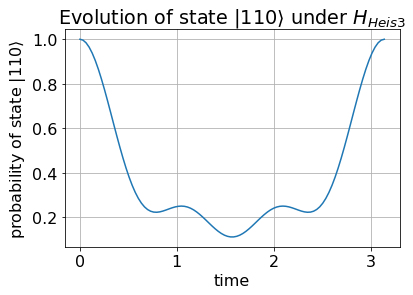

In [5]:
# Define array of time points
ts = np.linspace(0, np.pi, 100)

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis3(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis3(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value, or probability, of remaining in |110>
probs_110 = [np.abs((~initial_state @ U_heis3(float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110)
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis3}$')
plt.grid()
plt.show()

In [6]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

# Qiskit Pulse imports
import qiskit.pulse
from qiskit import pulse
from qiskit.pulse import library

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag

from scipy.special import erf

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# load IBMQ Account data
IBMQ.save_account('',overwrite=True )
IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [8]:

provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')

backend = provider.get_backend('ibmq_jakarta')

properties = backend.properties()

In [9]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [10]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [11]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx

def Exract_GaussianSquare(q1, q2):
    """Retrieve the Gaussiacross resonance pulse waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """
    cx = cx_pulse_instructions(q1, q2)
    cx1 = cx_pulse_instructions(q2, q1)
    if cx.instructions[-1][0] < cx1.instructions[-1][0]:
        cx=cx1
    idx = 0
    Dr_gs = []
    cr_gs = []
    control_channel=''
    Drive_Channel=''
    another_Drive_Channel=''
    #look for first Play instruction on a ControlChannel
    N = 1
    for i in range(len(cx.instructions)):
        if type(cx.instructions[i][1]) is ShiftPhase and type(cx.instructions[i][1].channel) is DriveChannel\
        and cx.instructions[i][1].phase == -math.pi/2 and N == 1 :
            
            another_Drive_Channel=cx.instructions[i][1].channels[0]
            
        if type(cx.instructions[i][1].channels[0]) is ControlChannel and type(cx.instructions[i][1]) is Play\
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            cr_gs.append(cx.instructions[i][1].pulse)

            control_channel=cx.instructions[i][1].channels[0]

        if type(cx.instructions[i][1].channels[0]) is DriveChannel and type(cx.instructions[i][1]) is Play \
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            Dr_gs.append(cx.instructions[i][1].pulse)

            Drive_Channel=cx.instructions[i][1].channels[0]
        if type(cx.instructions[i][1]) is Play:
            N=0

    return control_channel, cr_gs, Drive_Channel, Dr_gs, another_Drive_Channel


def Get_Shift_phase_CRTL_Chan(q1, q2):
    """Get q1 and q2 corresponding control channel
    
    Args:
      q1: small one
      qt: target qubit index
    """
    cx1 = cx_pulse_instructions(q1, q2)
    cx2 = cx_pulse_instructions(q2, q1)
    if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        cx1, cx2 = cx2, cx1
    control_chan0 = []
    control_chan1 = []
    for i in range(len(cx2.instructions)):
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi/2 :
            control_chan0.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi :
            control_chan1.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is Play:
            break

    return control_chan0, control_chan1


def Rzz_90_gate_schedule (q0,q1):
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    for Y in Y90p:
        if type(Y[1]) is Play:
            Y_pulse = Y[1].pulse
            
    drive_samples = Y_pulse.duration
    
    cr_samples = cr_pulse[0].duration
  
    Rzz_90_schedule = pulse.Schedule(name="RZZ gate m90 pulse") 
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) #<< int(2*cr_samples+2*drive_samples)
    
    for chan in control_chan1:
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) #<< int(2*cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(Y_pulse, Dchan)
    
    Rzz_90_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
    for chan in control_chan1: 
        Rzz_90_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)

    
    Rzz_90_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(cr_samples+drive_samples)

    Rzz_90_schedule |= Play(dr_pulse[1], Dchan) << int(cr_samples+2*drive_samples)
    Rzz_90_schedule |= Play(cr_pulse[1], uchan) << int(cr_samples+2*drive_samples)
    
    Rzz_90_schedule |= Play(X_180, another_Dchan) << int(2*cr_samples+2*drive_samples)

    Rzz_90_schedule |= Play(Y_pulse, Dchan) << int(2*cr_samples+2*drive_samples)
    
    return Rzz_90_schedule

def Rzz_gate_schedule (q0,q1,theta):
    
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Exract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    Frac = 2*np.abs(theta)/math.pi
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    ### find out Y_90 pulse 
    
    for Y in Y90p:
        
        if type(Y[1]) is Play:
            
            Y_pulse = Y[1].pulse
            
    ###
            
    drive_samples = Y_pulse.duration
    
    cr_samples = cr_pulse[0].duration
    
    cr_width= cr_pulse[0].width
    
    cr_sigma = cr_pulse[0].sigma
    
    cr_amp = np.abs(cr_pulse[0].amp)
    
    number_std = (cr_samples-cr_width)/cr_sigma
    
    Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std) 
    
    Area_pi_2 = cr_width*cr_amp+Area_g 
    
    dr_sigma = dr_pulse[0].sigma
    
    dr_amp = np.abs(dr_pulse[0].amp)
    
    Area_theta = Frac * Area_pi_2
    
    if Area_theta > Area_g:
        
        New_width = (Area_theta-Area_g)/cr_amp
        
        new_duration = math.ceil((New_width+number_std*cr_sigma)/16)*16
        
        New_width = new_duration-number_std*cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        
    else:
        
        New_amp_cr =  cr_pulse[0].amp*Area_theta/Area_g
        
        New_amp_dr= dr_pulse[0].amp*Area_theta/Area_g
        
        new_duration = number_std * cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=int(new_duration), amp=New_amp_cr, sigma=cr_sigma, width=0)
        
        cr_pulse[1] = GaussianSquare(duration=int(new_duration), amp=-New_amp_cr, sigma=cr_sigma, width=0)
        
        dr_pulse[0] = GaussianSquare(duration=int(new_duration), amp=New_amp_dr, sigma=dr_sigma, width=0)
        
        dr_pulse[1] = GaussianSquare(duration=int(new_duration), amp=-New_amp_dr, sigma=dr_sigma, width=0)
        
    # Set up the Rzz schedule
    if theta < 0 :
  
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) 
    
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) 
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse

        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
    
        return RZZ_schedule
    
    else:
        
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+2*drive_samples)
        
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+3*drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+3*drive_samples)
    
        return RZZ_schedule

In [12]:

# Noiseless simulated backend
sim = QasmSimulator()

In [13]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [14]:
heis_qr = QuantumRegister(2)
heis_qc = QuantumCircuit(heis_qr, name='heis')

heis_qc.rz(-np.pi/2,1)
heis_qc.cnot(1,0)
heis_qc.rz(np.pi/2-2 * t, 0)
heis_qc.ry(-np.pi/2+2 * t, 1)
heis_qc.cnot(0,1)
heis_qc.ry(np.pi/2-2 * t, 1)
heis_qc.cnot(1,0)
heis_qc.rz(np.pi/2,1)

# Convert custom quantum circuit into a gate
heis = heis_qc.to_instruction()

In [15]:
# Combine subcircuits into a single multiqubit gate representing a single trotter step
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

for i in range(num_qubits - 2, -1,-1):
    Trot_qc.append(heis, [Trot_qr[i], Trot_qr[i+1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

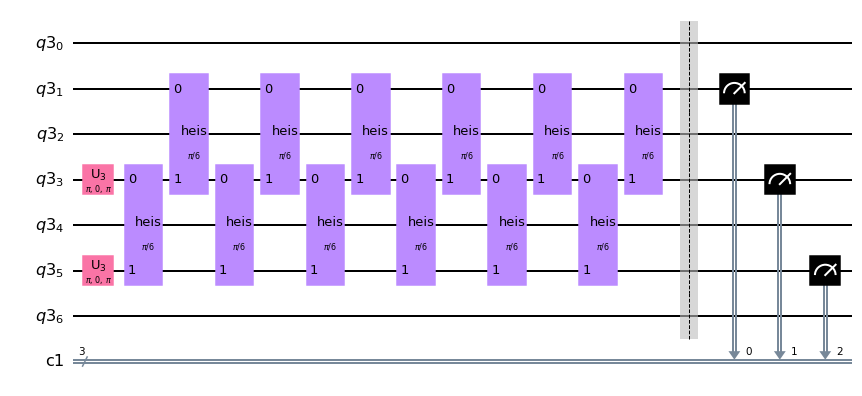

In [17]:
# The final time of the state evolution
#epsilon=0.15

target_time = np.pi

# Number of trotter steps
trotter_steps =6 ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

#t=(target_time/trotter_steps)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
for _ in range(trotter_steps):
    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
qc = qc.bind_parameters({t: target_time/trotter_steps})

# Generate state tomography circuits to evaluate fidelity of simulation
st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])

# Display circuit for confirmation
st_qcs[-1].decompose().draw('mpl') 

#st_qcs[-1].draw('mpl')

In [18]:
def DD_circuit1(circuit, backend, qubits_list, initial_layout = None, name=False):

  if initial_layout:

    circuit = transpile(circuit, backend, optimization_level=3, scheduling_method='asap',initial_layout =init_layout)

  else:

    circuit = transpile(circuit, backend, optimization_level=3, scheduling_method='asap')

  if name:

    DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs,name=circuit.name)

  else:

    DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs)
  
  for operation in circuit[:]:

    if type(operation[0])==qiskit.circuit.delay.Delay:

      if  operation[0].duration >= 400 and operation[0].duration < 800:

        q_index = operation[1][0].index

        if q_index in qubits_list:

          t=(operation[0].duration-320)//4

          t = math.ceil((t)/16)*16

          DD_cir.delay(t,[q_index],'dt')

          DD_cir.x(q_index)

          DD_cir.delay(2*t,[q_index],'dt')

          DD_cir.z(q_index)

          DD_cir.x(q_index)

          DD_cir.z(q_index)

      elif operation[0].duration >= 800:

        q_index = operation[1][0].index

        if q_index in qubits_list:

          t=(operation[0].duration-640)//8

          t = math.ceil((t)/16)*16

          DD_cir.delay(t,[q_index],'dt')

          DD_cir.rx(np.pi,q_index)

          DD_cir.delay(2*t,[q_index],'dt')

          DD_cir.ry(np.pi,q_index)

          DD_cir.delay(2*t,[q_index],'dt')

          DD_cir.rx(np.pi,q_index)

          DD_cir.delay(2*t,[q_index],'dt')

          DD_cir.ry(np.pi,q_index)

        else:

          DD_cir.data.append(operation)

      else:
        
        DD_cir.data.append(operation)

    else:

      DD_cir.data.append(operation)

  return DD_cir

In [19]:
def DD_circuit(circuit, backend, qubits_list, initial_layout = None, name=False):

  if initial_layout:

    circuit = transpile(circuit, backend, optimization_level=3, scheduling_method='asap',initial_layout =init_layout)

  else:

    circuit = transpile(circuit, backend, optimization_level=3, scheduling_method='asap')

  if name:

    DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs,name=circuit.name)

  else:

    DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs)
  
  for operation in circuit[:]:

    if type(operation[0])==qiskit.circuit.delay.Delay:

      if  operation[0].duration >= 400:

        q_index = operation[1][0].index

        if q_index in qubits_list:

          t=(operation[0].duration-320)//4

          t = math.ceil((t)/16)*16

          DD_cir.delay(t,[q_index],'dt')

          DD_cir.x(q_index)

          DD_cir.delay(2*t,[q_index],'dt')

          DD_cir.z(q_index)

          DD_cir.x(q_index)

          DD_cir.z(q_index)

        else:

          DD_cir.data.append(operation)

      else:
        
        DD_cir.data.append(operation)

    else:

      DD_cir.data.append(operation)

  return DD_cir

In [20]:
from qiskit import *
import qiskit

In [21]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [ ]:
qubits_list = [1,3,5]

cirs=[]

for i in range(len(st_qcs)):

    cir=DD_circuit(st_qcs[i], backend, qubits_list , name=True)

    cirs.append(cir)

In [ ]:
qubits_list = [1,3,5]

shots=8192

qr = QuantumRegister(len(qubits_list),'q')

#sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

#backend = jakarta

meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [ ]:


init_layout = {}

for i,j in enumerate(qubits_list):

    init_layout[qr[i]] = j

cal_results = execute(meas_calibs, backend, shots=shots, initial_layout=init_layout)

print('Job ID', cal_results.job_id())

Job ID 624c6eed69892808d40037f4


In [ ]:
shots = 8192
reps = 4

#sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
#backend = sim_noisy_jakarta
# reps = 8
#backend = jakarta

jobs = []
for _ in range(reps):
    # execute
    job = execute(cirs, backend, shots=shots)
    #job = execute(st_qcs, backend, shots=shots)
    print('Job ID', job.job_id())
    jobs.append(job)

Job ID 624c6ef0f65d78ca9138f3da
Job ID 624c6ef3d72033525367c9a5
Job ID 624c6ef5d72033f98267c9a6
Job ID 624c6efb4b515253947c5bf6


In [ ]:
for job in jobs:
    job_monitor(job)
    try:
        if job.error_message() is not None:
            print(job.error_message())
    except:
        pass

Job Status: job is queued (492)

In [ ]:
cal_results=backend.retrieve_job('624c6eed69892808d40037f4')

ids=['624c6ef0f65d78ca9138f3da','624c6ef3d72033525367c9a5','624c6ef5d72033f98267c9a6','624c6efb4b515253947c5bf6']
jobs=[]
for id in ids:
  jobs.append(backend.retrieve_job(id))

In [ ]:
meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels)

meas_filter = meas_fitter.filter

In [ ]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results

    mit_result = meas_fitter.filter.apply(result)

    tomo_fitter = StateTomographyFitter(mit_result, st_qcs)

    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

# Compute tomography fidelities for each repetition

fids = []
for job in jobs:
    fid = state_tomo(job.result(), st_qcs)
    fids.append(fid)
    
print('state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))

state tomography fidelity = 0.5705 ± 0.0080


In [ ]:
fids

[0.559019041412502, 0.5677427654038545, 0.5748001996966093, 0.5803688593302253]

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table